<a href="https://colab.research.google.com/github/alfrizzle/NLP-Projects/blob/master/SpaCy_PhraseExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install visualise-spacy-tree
!pip install -U spacy

In [2]:
import spacy
import re
import pandas as pd
import numpy as np
from spacy.matcher import Matcher 
from spacy import displacy 
import visualise_spacy_tree
from IPython.display import Image, display
! python -m spacy download en_core_web_sm

2021-08-08 17:58:07.042552: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 13.6 MB 34.8 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
! python -m spacy info

2021-08-08 17:58:14.694731: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

============================== Info about spaCy ==============================

spaCy version    3.1.1                         
Location         /usr/local/lib/python3.7/dist-packages/spacy
Platform         Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic
Python version   3.7.11                        
Pipelines        en_core_web_sm (3.1.0)        



In [32]:
df=pd.DataFrame([[12,"3 army commanders were wounded and four civilians were injured by bombs. 10 gunmen carrying rifles were injured. There were a total of 20 civilian fatalities."],
                 [18,"5 army commanders were wounded and two civilians were injured by bombs. 14 gunmen carrying rifles were injured. There were a total of 30 civilian fatalities."],
                 [23,"39 army commanders were wounded and fifty civilians were injured by bombs. 58 gunmen carrying rifles were injured. There were a total of 23 civilian fatalities."],
                 [24,"20 army commanders were wounded and zero civilians were injured by bombs. 3 gunmen carrying rifles were injured. There were a total of 49 civilian fatalities."],
                 ],columns=["id","text"])

In [33]:
sample_text = df['text'][0]
sample_text

'3 army commanders were wounded and four civilians were injured by bombs. 10 gunmen carrying rifles were injured. There were a total of 20 civilian fatalities.'

In [6]:
# nlp = spacy.load('en_core_web_sm')
nlp = spacy.load('en_core_web_sm',disable=['ner','textcat'])
doc = nlp(text)

In [7]:
# function to preprocess speech
def clean(text):
    
    # removing paragraph numbers
    text = re.sub('[0-9]+.\t','',str(text))
    # removing new line characters
    text = re.sub('\n ','',str(text))
    text = re.sub('\n',' ',str(text))
    # removing apostrophes
    text = re.sub("'s",'',str(text))
    # removing hyphens
    text = re.sub("-",' ',str(text))
    text = re.sub("— ",'',str(text))
    # removing quotation marks
    text = re.sub('\"','',str(text))
    # removing salutations
    text = re.sub("Mr\.",'Mr',str(text))
    text = re.sub("Mrs\.",'Mrs',str(text))
    # removing any reference to outside text
    text = re.sub("[\(\[].*?[\)\]]", "", str(text))
    
    return text

In [8]:
# split sentences
def sentences(text):
    # split sentences and questions
    text = re.split('[.?]', text)
    clean_sent = []
    for sent in text:
        clean_sent.append(sent)
    return clean_sent

In [9]:
# preprocessing speeches
text_cleaned = clean(doc)
text_cleaned = sentences(text_cleaned)
print(text_cleaned)

['3 army commanders were wounded and four civilians were injured by bombs', ' 10 gunmen carrying rifles were injured', ' There were a total of 20 civilian fatalities', '']


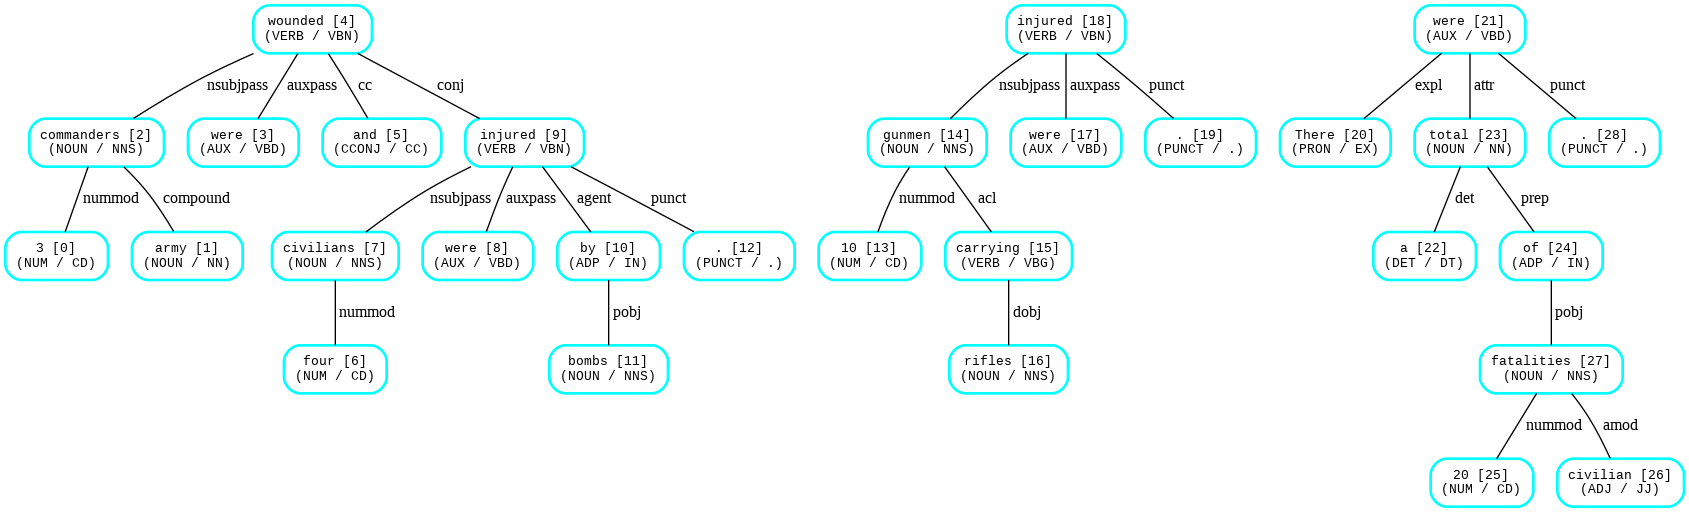

In [10]:
png = visualise_spacy_tree.create_png(doc)
display(Image(png))

In [7]:
from spacy import displacy

# Since this is an interactive Jupyter environment, we can use displacy.render here
displacy.render(doc, style='dep', jupyter=True, options={'distance':150})

In [8]:
# for token in doc:
#     print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
#             token.shape_, token.is_alpha, token.is_stop)
    

for token in doc:
    print(token.text, '=>' , token.dep_, '=>', token.pos_)

3 => nummod => NUM
army => compound => NOUN
commanders => nsubjpass => NOUN
were => auxpass => AUX
wounded => ROOT => VERB
and => cc => CCONJ
four => nummod => NUM
civilians => nsubjpass => NOUN
were => auxpass => AUX
injured => conj => VERB
by => agent => ADP
bombs => pobj => NOUN
. => punct => PUNCT
10 => nummod => NUM
gunmen => nsubjpass => NOUN
carrying => acl => VERB
rifles => dobj => NOUN
were => auxpass => AUX
injured => ROOT => VERB
. => punct => PUNCT
There => expl => PRON
were => ROOT => AUX
a => det => DET
total => attr => NOUN
of => prep => ADP
20 => nummod => NUM
civilian => amod => ADJ
fatalities => pobj => NOUN
. => punct => PUNCT


# Dependency Matcher

**Resources:**
* https://spacy.io/usage/rule-based-matching#dependencymatcher
* https://applied-language-technology.readthedocs.io/en/latest/notebooks/part_iii/02_pattern_matching.html



In [9]:
from spacy.matcher import DependencyMatcher

In [14]:
nlp = spacy.load("en_core_web_sm")
dep_matcher = DependencyMatcher(nlp.vocab)

In [15]:
# # Define a list with nested dictionaries that contains the pattern to be matched
# dep_pattern = [{'RIGHT_ID': 'verb', 'RIGHT_ATTRS': {'POS': 'VERB'}},
#                {'LEFT_ID': 'verb', 'REL_OP': '>', 'RIGHT_ID': 'subject', 'RIGHT_ATTRS': {'DEP': 'nsubj'}}
#               ]

In [16]:
dep_pattern = [
    {
        "RIGHT_ID": "anchor_number",
        "RIGHT_ATTRS": {"DEP": "nummod"}
    },
    {
        "LEFT_ID": "anchor_number",
        "REL_OP": "<",
        "RIGHT_ID": "number_noun",
        "RIGHT_ATTRS": {"POS": "NOUN"},
    },
    # {
    #     "LEFT_ID": "number_noun",
    #     "REL_OP": ".*",
    #     "RIGHT_ID": "noun_compound",
    #     "RIGHT_ATTRS": {"DEP": "compound"},
    # },
    {
        "LEFT_ID": "number_noun",
        "REL_OP": "<",
        "RIGHT_ID": "noun_verb",
        "RIGHT_ATTRS": {"POS": "VERB"},
    }
]

In [17]:
# Add the pattern to the matcher under the name 'num_noun_verb'
dep_matcher.add('num_noun_verb', patterns=[dep_pattern])

# Apply the DependencyMatcher to the Doc object under 'doc'; Store the result 
# under the variable 'dep_matches'.
dep_matches = dep_matcher(doc)

# Call the variable to examine the output
dep_matches

[(13502375259481113420, [0, 2, 4]),
 (13502375259481113420, [6, 7, 9]),
 (13502375259481113420, [13, 14, 18])]

In [18]:
print(len(dep_matches))
dep_matches[0]

3


(13502375259481113420, [0, 2, 4])

In [19]:
dep_matches[0]

(13502375259481113420, [0, 2, 4])

In [20]:
dep_matches_v2 = dep_matches[4:]
dep_matches_v2

[]

In [21]:
# Loop over each tuple in the list 'dep_matches'
for match in dep_matches:
    
    # Take the first item in the tuple at [0] and assign it under
    # the variable 'pattern_name'. This item is a spaCy Lexeme object.
    pattern_name = match[0]
    
    # Take the second item in the tuple at [1] and assign it under
    # the variable 'matches'. This is a list of indices referring to the
    # Doc object under 'doc' that we just matched.
    matches = match[1]
    
    # Let's unpack the matches list into variables for clarity
    # num, noun = matches[0], matches[1]
    num, noun, verb = matches[0], matches[1], matches[2]
    # num = matches[0]
    
    # Print the matches by first fetching the name of the pattern from the 
    # Vocabulary object. Next, use the 'subject' and 'verb' variables to 
    # index the Doc object. This gives us the actual Tokens matched. Use a
    # tabulator ('\t') and some stops ('...') to separate the output.
    # print(nlp.vocab[pattern_name].text, '\t', doc[num], doc[noun])
    print(nlp.vocab[pattern_name].text, ':\t', doc[num], doc[noun], doc[verb])
    # print(nlp.vocab[pattern_name].text, '\t', doc[num])

num_noun_verb :	 3 commanders wounded
num_noun_verb :	 four civilians injured
num_noun_verb :	 10 gunmen injured


## Pattern 1: NUM-NOUN-VERB

In [67]:
nlp = spacy.load("en_core_web_sm")
dep_matcher = DependencyMatcher(nlp.vocab)

# define dependency parsing pattern
dep_pattern = [
    {
        "RIGHT_ID": "anchor_number",
        "RIGHT_ATTRS": {"DEP": "nummod"}
    },
    {
        "LEFT_ID": "anchor_number",
        "REL_OP": "<",
        "RIGHT_ID": "number_noun",
        "RIGHT_ATTRS": {"POS": "NOUN"},
    },
    {
        "LEFT_ID": "number_noun",
        "REL_OP": "<",
        "RIGHT_ID": "noun_verb",
        "RIGHT_ATTRS": {"POS": "VERB"},
    }
]

# Add the pattern to the matcher under the name 'num_noun_verb'
dep_matcher.add('num_noun_verb', patterns=[dep_pattern])
# Apply the DependencyMatcher to the Doc object under 'doc'; Store the result 
# under the variable 'dep_matches'.
dep_matches = dep_matcher(doc)
print('pattern matches output:', dep_matches,'\n')


# match_id, token_ids = dep_matches[0]
# for i in range(len(token_ids)):
#     print(dep_pattern[i]["RIGHT_ID"] + ":", doc[token_ids[i]].text)

output = []
# Loop over each tuple in the list 'dep_matches'
for match in dep_matches:
    pattern_name = match[0]
    matches = match[1]
    num, noun, verb = matches[0], matches[1], matches[2]
    # print(nlp.vocab[pattern_name].text, ':\t', doc[num], doc[noun], doc[verb])
    text = doc[num], doc[noun], doc[verb]
    # print(text)
    output.append(text)

print(output)

# new_output = str('\n'.join(map(lambda x: str(x[0]) + ' ' + str(x[1]) + ' ' + str(x[2]), output)))
new_output = ('\n'.join(map(lambda x: str(x[0]) + ' ' + str(x[1]) + ' ' + str(x[2]), output))).split('\n')
# '\n'.join(str(x) for x in output)
# ' '.join(map(lambda x: str(x), output))
# ' '.join(str(i) for i in output)
final_output = ', '.join(new_output)

# "\n".join(str(el) for el in mytuple)
# final_output = new_output.splitlines()
# final_output = new_output.split('\n')

# tuple_strings = ['(%s, %s, %s)' % tuple for tuple in output]

# result = ', '.join(tuple_strings)
# print(result)

# sub_text = ''    
# if(len(dep_matches) > 0):
#   # span = doc[dep_matches[0][1]:dep_matches[0][3]]
#   span = doc[dep_matches[0][1]]
#   sub_text = span.text
#   # remove punct
#   sub_text = sub_text[:-1]
#   tokens = sub_text.split(' ')

#   print(' '.join(tokens[1:]))

pattern matches output: [(13502375259481113420, [0, 2, 4]), (13502375259481113420, [6, 7, 9]), (13502375259481113420, [13, 14, 18])] 

[(3, commanders, wounded), (four, civilians, injured), (10, gunmen, injured)]


'3 commanders wounded, four civilians injured, 10 gunmen injured'

## Pattern 1 Function

In [89]:
def extract(text):
  nlp = spacy.load("en_core_web_sm")
  doc = nlp(text)
  dep_matcher = DependencyMatcher(nlp.vocab)

  # define dependency parsing pattern
  dep_pattern = [
      {
          "RIGHT_ID": "anchor_number",
          "RIGHT_ATTRS": {"DEP": "nummod"}
      },
      {
          "LEFT_ID": "anchor_number",
          "REL_OP": "<",
          "RIGHT_ID": "number_noun",
          "RIGHT_ATTRS": {"POS": "NOUN"},
      },
      {
          "LEFT_ID": "number_noun",
          "REL_OP": "<",
          "RIGHT_ID": "noun_verb",
          "RIGHT_ATTRS": {"POS": "VERB"},
      }
  ]

  # Add the pattern to the matcher under the name 'num_noun_verb'
  dep_matcher.add('num_noun_verb', patterns=[dep_pattern])
  # Apply the DependencyMatcher to the Doc object under 'doc'; Store the result 
  # under the variable 'dep_matches'.
  dep_matches = dep_matcher(doc)

  # initiate list to store matches
  output = []

  # Loop over each tuple in the list 'dep_matches'
  for match in dep_matches:
      pattern_name = match[0]
      matches = match[1]
      num, noun, verb = matches[0], matches[1], matches[2]
      # print(nlp.vocab[pattern_name].text, ':\t', doc[num], doc[noun], doc[verb])
      text = doc[num], doc[noun], doc[verb]
      # print(text)
      output.append(text)

  # convert tuples to string separated by comma
  new_output = (', '.join(map(lambda x: str(x[0]) + ' ' + str(x[1]) + ' ' + str(x[2]), output)))
  
  return new_output

In [92]:
# test function on single sentence
extract(sample_text)

'3 commanders wounded, four civilians injured, 10 gunmen injured'

In [91]:
# test function on dataframe
df['matches'] = df['text'].apply(lambda x: extract(x))
df

,id,text,matches
0,12,3 army commanders were wounded and four civili...,"3 commanders wounded, four civilians injured, ..."
1,18,5 army commanders were wounded and two civilia...,"5 commanders wounded, two civilians injured, 1..."
2,23,39 army commanders were wounded and fifty civi...,"39 commanders wounded, fifty civilians injured..."
3,24,20 army commanders were wounded and zero civil...,"20 commanders wounded, zero civilians injured,..."
